### Semantic Instance Segmentation with a Discriminative Loss Function

**Reference:**
De Brabandere, B., Neven, D., & Van Gool, L. (2017). Semantic instance segmentation with a discriminative loss function. arXiv preprint arXiv:1708.02551.
    
**Description:** As opposed to region-proposal approaches to instance segmentation, with this method the model produces a d-dimensional embedding for each input pixel.
A discriminative loss function ensures that the embeddings of pixels belonging to the same instance will be pulled close together, whereas pixels belonging to different instances are pushed away.
A simple clustering approach is used at test time to group the embeddings into detected instances.

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from datasets.utils import generate_train_and_test_data
from datasets.instanceseg.sticks import sticks_instance_segmentation_sample

Our goal will be to reproduce the small example from the original paper where they trained a simple stick detector:

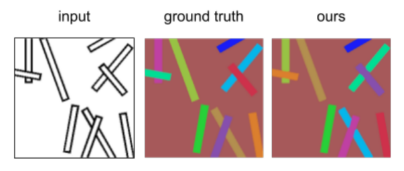

In [3]:
(X_train, Y_train), (X_test, Y_test) = \
    generate_train_and_test_data(sticks_instance_segmentation_sample, width=128, height=128, n_samples_train=10000, n_samples_test=100)

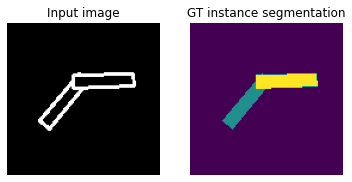

In [4]:
ax1, ax2 = plt.subplot(1,2,1), plt.subplot(1,2,2)
ax1.imshow(X_train[0], cmap="gray")
ax1.axis("off")
ax1.set_title("Input image")

ax2.imshow(Y_train[0][...,0])
ax2.axis("off")
ax2.set_title("GT instance segmentation")
plt.show()

In [5]:
X_train = X_train / 255
X_test = X_test / 255

The model will be a small Unet-like FCNN with two outputs:

1) The predicted segmentation mask, with sigmoid activation and one channel

2) The predicted pixel embeddings, with linear activation and three channels

In [6]:
def create_model(embedding_dim=3):

    # Encoder part of the Unet
    input = keras.layers.Input((128, 128, 1))
    conv1 = keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(input) 
    maxp1 = keras.layers.MaxPool2D((2,2))(conv1)                                    
    conv2 = keras.layers.Conv2D(64, (3,3), activation="relu", padding="same")(maxp1) 
    maxp2 = keras.layers.MaxPool2D((2,2))(conv2)                                     
    conv3 = keras.layers.Conv2D(128, (3,3), activation="relu", padding="same")(maxp2)
    maxp3 = keras.layers.MaxPool2D((2,2))(conv3)  
    conv4 = keras.layers.Conv2D(256, (3,3), activation="relu", padding="same")(maxp3)
    maxp4 = keras.layers.MaxPool2D((2,2))(conv4)

    # Decoder part of the Unet
    tconv5 = keras.layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding="same", activation="relu")(maxp4) 
    con5 = keras.layers.concatenate([tconv5, conv4], axis=3)
    tconv6 = keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same", activation="relu")(con5)  
    con6 = keras.layers.concatenate([tconv6, conv3], axis=3)  
    tconv7 = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(con6)  
    con7 = keras.layers.concatenate([tconv7, conv2], axis=3)                      
    tconv8 = keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same", activation="relu")(con7)  
    con8 = keras.layers.concatenate([tconv8, conv1], axis=3)   
    
    # Split into two output maps: pixel embeddings and segmentation mask
    embedding = keras.layers.Conv2D(embedding_dim, kernel_size=1, padding="same", activation="linear", use_bias=False, name="embedding")(con8)
    segmentation = keras.layers.Conv2D(1, (1,1), padding="same", activation="sigmoid", name="segmentation")(con8)
    return keras.models.Model(input, [segmentation, embedding])
    

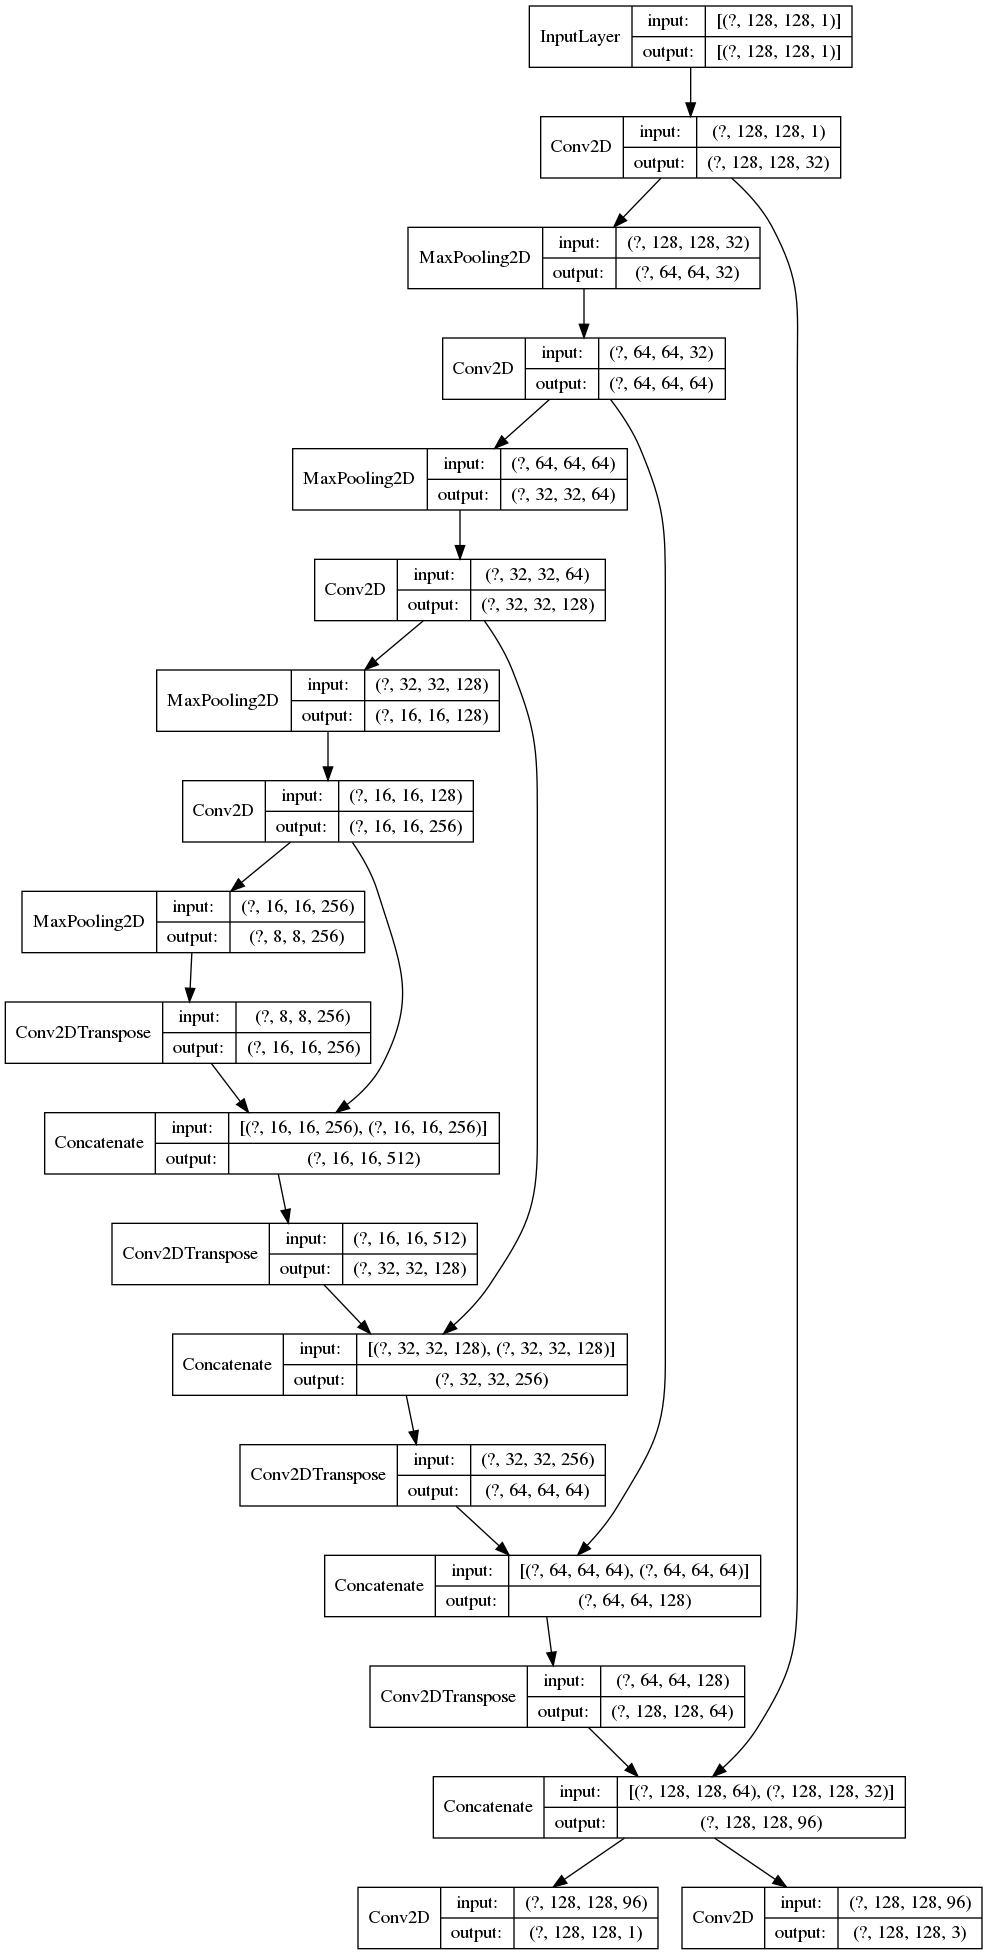

In [7]:
model = create_model()
keras.utils.plot_model(model, show_layer_names=False, show_shapes=True)

The loss function is not too complex, but it is a bit messy to implement in terms of tensorflow operations.

Here we just borrow the implementation from REF 1. Check the original paper for details about the discriminative loss function.

REF 1: https://github.com/hq-jiang/instance-segmentation-with-discriminative-loss-tensorflow

In [8]:
def discriminative_loss_single(
        prediction,
        correct_label,
        feature_dim,
        label_shape,
        delta_v,
        delta_d,
        param_var,
        param_dist,
        param_reg):
    """
    discriminative loss
    :param prediction: inference of network
    :param correct_label: instance label
    :param feature_dim: feature dimension of prediction
    :param label_shape: shape of label
    :param delta_v: cut off variance distance
    :param delta_d: cut off cluster distance
    :param param_var: weight for intra cluster variance
    :param param_dist: weight for inter cluster distances
    :param param_reg: weight regularization
    """
    correct_label = tf.reshape(
        correct_label, [label_shape[1] * label_shape[0]]
    )
    reshaped_pred = tf.reshape(
        prediction, [label_shape[1] * label_shape[0], feature_dim]
    )
    
    foreground_mask = tf.not_equal(correct_label, 0)
    correct_label = tf.boolean_mask(correct_label, foreground_mask)
    reshaped_pred = tf.boolean_mask(reshaped_pred, foreground_mask)

    # calculate instance nums
    unique_labels, unique_id, counts = tf.unique_with_counts(correct_label)
    counts = tf.cast(counts, tf.float32)
    num_instances = tf.size(unique_labels)

    # calculate instance pixel embedding mean vec
    segmented_sum = tf.math.unsorted_segment_sum(
        reshaped_pred, unique_id, num_instances)
    mu = tf.divide(segmented_sum, tf.reshape(counts, (-1, 1)))
    mu_expand = tf.gather(mu, unique_id)

    distance = tf.norm(tf.subtract(mu_expand, reshaped_pred), axis=1, ord=1)
    distance = tf.subtract(distance, delta_v)
    distance = tf.clip_by_value(distance, 0., distance)
    distance = tf.square(distance)

    l_var = tf.math.unsorted_segment_sum(distance, unique_id, num_instances)
    l_var = tf.divide(l_var, counts)
    l_var = tf.reduce_sum(l_var)
    l_var = tf.divide(l_var, tf.cast(num_instances, tf.float32))

    mu_interleaved_rep = tf.tile(mu, [num_instances, 1])
    mu_band_rep = tf.tile(mu, [1, num_instances])
    mu_band_rep = tf.reshape(
        mu_band_rep,
        (num_instances *
         num_instances,
         feature_dim))

    mu_diff = tf.subtract(mu_band_rep, mu_interleaved_rep)

    intermediate_tensor = tf.reduce_sum(tf.abs(mu_diff), axis=1)
    zero_vector = tf.zeros(1, dtype=tf.float32)
    bool_mask = tf.not_equal(intermediate_tensor, zero_vector)
    mu_diff_bool = tf.boolean_mask(mu_diff, bool_mask)

    mu_norm = tf.norm(mu_diff_bool, axis=1, ord=1)
    mu_norm = tf.subtract(2. * delta_d, mu_norm)
    mu_norm = tf.clip_by_value(mu_norm, 0., mu_norm)
    mu_norm = tf.square(mu_norm)

    l_dist = tf.reduce_mean(mu_norm)
    l_reg = tf.reduce_mean(tf.norm(mu, axis=1, ord=1))

    param_scale = 1.
    l_var = param_var * l_var
    l_dist = param_dist * l_dist
    l_reg = param_reg * l_reg

    loss = param_scale * (l_var + l_dist + l_reg)
    loss = tf.cond(num_instances > 0 , lambda: loss, lambda: 0.)
    return loss, l_var, l_dist, l_reg


def discriminative_loss(correct_label, prediction, feature_dim=3, image_shape=(128,128), 
                delta_v=0.5, delta_d=1.5, param_var=1, param_dist=1, param_reg=0.001):
    ''' Iterate over a batch of prediction/label and cumulate loss
    :return: discriminative loss and its three components
    '''
    def cond(label, batch, out_loss, out_var, out_dist, out_reg, i):
        return tf.less(i, tf.shape(batch)[0])

    def body(label, batch, out_loss, out_var, out_dist, out_reg, i):
        disc_loss, l_var, l_dist, l_reg = discriminative_loss_single(prediction[i], correct_label[i], feature_dim, image_shape, 
                        delta_v, delta_d, param_var, param_dist, param_reg)

        out_loss = out_loss.write(i, disc_loss)
        out_var = out_var.write(i, l_var)
        out_dist = out_dist.write(i, l_dist)
        out_reg = out_reg.write(i, l_reg)

        return label, batch, out_loss, out_var, out_dist, out_reg, i + 1

    # TensorArray is a data structure that support dynamic writing
    output_ta_loss = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    output_ta_var = tf.TensorArray(dtype=tf.float32,  size=0, dynamic_size=True)
    output_ta_dist = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
    output_ta_reg = tf.TensorArray(dtype=tf.float32,  size=0, dynamic_size=True)

    _, _, out_loss_op, _, _, _, _  = tf.while_loop(
        cond, body, [correct_label, prediction, output_ta_loss, output_ta_var, output_ta_dist, output_ta_reg, 0])
    
    out_loss_op = out_loss_op.stack()
    disc_loss = tf.reduce_mean(out_loss_op)

    return disc_loss

The model is trained using a combination of two loss functions, each applied to one of the outputs of the model:

1) Binary crossentropy which is applied to the segmentation masks produced by the first output of the model 

2) The discriminative loss function which is applied to the pixel embeddings produced by the second output

In [ ]:
from tensorflow import keras
from tensorflow.keras.losses import binary_crossentropy

losses = [binary_crossentropy, discriminative_loss]
model.compile("adam", loss=losses)

# Since background class is represented with 0s in the instance maps of Y_train
# we can get the target segmentation masks by doing Y_train > 0
Y_train_segmentation_masks, Y_train_instance_maps = Y_train > 0, Y_train

model.fit(X_train, [Y_train_segmentation_masks, Y_train_instance_maps], epochs=100, batch_size=32)

To actually use the trained model to generate instance segmentation predictions, we need a simple clustering method
to group predicted embeddings into individual instances. The following function implements the method described in the original paper:


_We select a random unlabeled pixel and threshold around its embedding. Next however, we calculate the mean of the_

_selected group of embeddings and use the mean to threshold again. We repeat this process until mean convergence. This has the_

_effect of moving to a high-density area in feature space, likely corresponding to a true cluster center._



In [10]:
from sklearn.neighbors import NearestNeighbors

def embeddings_to_instances(embeddings_map, segmentation, embedding_distance_threshold = 0.5,
        segmentation_threshold = 0.5, center_change_tol = 0.001, min_samples_per_instance = 10):
    
    embedding_dim = embeddings_map.shape[-1]
    
    # Select the embeddings corresponding to positive regions in the segmentation mask
    relevant_embedding_selection_mask = (segmentation > segmentation_threshold).ravel()
    embeddings = embeddings_map.reshape((-1, embedding_dim))[relevant_embedding_selection_mask]
    
    nn = NearestNeighbors().fit(embeddings)
    
    labels = np.full(len(embeddings), -1, dtype=np.int32)
    
    instance_id = 0
    while np.any(labels == -1):
        
        unclustered_idxs = np.where(labels == -1)[0]
        seed_idx = unclustered_idxs[np.random.randint(len(unclustered_idxs))]
        
        center = embeddings[seed_idx]
        
        center_change = np.inf
        while center_change > center_change_tol:
            in_radius_idxs = nn.radius_neighbors(
                [center], return_distance=False, radius=embedding_distance_threshold)[0]
            new_center = np.mean(embeddings[in_radius_idxs], axis=0) if len(in_radius_idxs) > 0 else center
            
            center_change = np.linalg.norm(center - new_center)
            center = new_center

        labels[in_radius_idxs] = instance_id
        labels[seed_idx] = instance_id
        instance_id += 1
        
        points_left = np.sum(labels==-1)
    
    # Remove detected instances with less than min_samples_per_instance pixels
    values, counts = np.unique(labels, return_counts=True)
    for (label, count) in zip(values, counts):
        if count < min_samples_per_instance:            
            labels[labels == label] = -1
        
    # Make sure predicted instance labels are contiguous
    new_label = 0
    for label in np.unique(labels):
        if label != -1:
            labels[labels == label] = new_label
            new_label += 1
        
    full_image_labels = np.full(np.prod(embeddings_map.shape[:2]), -1, dtype=np.int32)
    full_image_labels[relevant_embedding_selection_mask] = labels
    
    return full_image_labels.reshape(embeddings_map.shape[:2])
    


Once the model is trained, there are a bunch of things we can plot to see how things are going for a test sample. In particular, we will show:

1) Input grayscale image

2) Ground Truth instance segmentation map

3) Semantic segmentation mask prediction

4) Three dimensions of the pixel embeddings as RGB values for an image

5) Predicted instance segmentation map after clustering of the embeddings


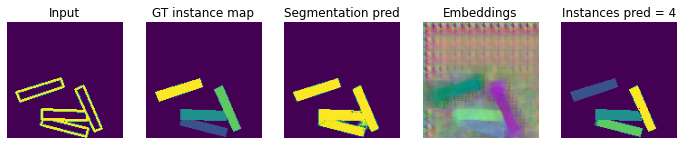

Detected instances:


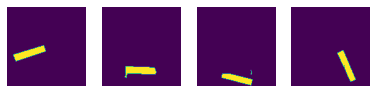

In [24]:
idx = np.random.randint(X_test.shape[0])
plt.figure(figsize=(12,8))
ax = plt.subplot(151)
ax.imshow(X_test[idx])
ax.axis("off")
ax.set_title("Input")
ax = plt.subplot(152)
segmentation = Y_test[idx,:,:,0] > 0
ax.imshow(Y_test[idx,:,:,0])
ax.axis("off")
ax.set_title("GT instance map")

segmentation_pred, embedding_pred = model.predict(X_test[idx:idx+1])
segmentation_pred, embedding_pred = segmentation_pred[0], embedding_pred[0]
embedding_pred_scaled = embedding_pred - np.min(embedding_pred)
embedding_pred_scaled = embedding_pred_scaled / np.max(embedding_pred_scaled)

ax = plt.subplot(153)
ax.imshow(segmentation_pred[...,0])
ax.set_title("Segmentation pred")
ax.axis("off")

ax = plt.subplot(154)
ax.imshow(embedding_pred_scaled)
ax.set_title("Embeddings")
ax.axis("off")

discretized_emb = embeddings_to_instances(embedding_pred, segmentation>0, embedding_distance_threshold=1.0)

ax = plt.subplot(155)
ax.imshow(discretized_emb)
ax.set_title(f"Instances pred = {len(np.unique(discretized_emb))-1}")
ax.axis("off")
plt.show()


plt.figure(figsize=(15,12))
print("Detected instances:")
for i, label in enumerate(np.unique(discretized_emb)):
    if label != -1:
        ax = plt.subplot(191+i)
        ax.imshow(discretized_emb == label)
        ax.axis("off")
plt.show()